<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/notebooks/pyro_2d_ctf_poisson_amortized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
* 2d ctf and shift amortized

# Setup

In [3]:
! pip3 install pyro-ppl 

     |████████████████████████████████| 713 kB 5.1 MB/s 


In [259]:
import pyro
import torch
import matplotlib.pyplot as plt
import pyro.distributions as dist
import pandas as pd
import numpy as np
import torch
from torch import tensor, nn
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from sklearn.metrics import confusion_matrix

def doplt(arr_2d): return plt.imshow(arr_2d.detach().numpy(), cmap='gray')
pyro.set_rng_seed(101)


# atom blobs

In [135]:
torch.random.manual_seed(2)
num_pix=64
atom_centers_dist = dist.Uniform(low=-num_pix/3.,high=num_pix/3.)
num_atoms = 10
n_dim = 2
atom_centers_gt = torch.zeros(num_atoms,n_dim)
for idx_atoms in range(num_atoms):
  for idx_dim in range(n_dim):
    atom_centers_gt[idx_atoms,idx_dim] = atom_centers_dist.sample()
atom_centers_gt.shape

torch.Size([10, 2])

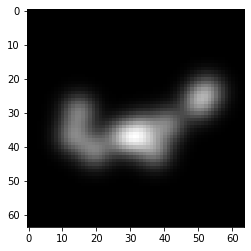

In [136]:
def make_coords(num_pix):
  assert n_dim == 2
  ax = torch.arange(-num_pix//2, num_pix//2)
  X = torch.meshgrid(ax, ax, indexing='ij')
  coords = torch.zeros(X[0].size().numel(), n_dim)
  for di in range(n_dim):
    coords[:, di] = X[di].flatten()
  return coords

coords = make_coords(num_pix)
sigma_signal_gt = tensor(3.5)

def make_clean_signal_multi_atom(atom_centres,coords,sigma_signal_gt):
  clean_signal = torch.zeros(coords.shape[0])
  for atom_center in atom_centres:
    clean_signal += torch.exp(-((coords-atom_center)**2).sum(-1)/(2*sigma_signal_gt**2))
  return clean_signal

clean_signal = make_clean_signal_multi_atom(atom_centers_gt,coords,sigma_signal_gt).reshape(num_pix,num_pix)
doplt(clean_signal)

# synthetic shifted data

In [7]:
def angle_to_rotation(angle_rad):
  c,s = torch.cos(angle_rad), torch.sin(angle_rad)
  rotation = torch.tensor([[c,-s],
               [s,c]])
  return rotation

shift_loc_gt = tensor(0.)
shift_scale_gt = tensor(10.)
gt_dist = dist.Normal(shift_loc_gt,shift_scale_gt)

n_particles=1000
angle_rad_gt = torch.zeros(n_particles)
shift_gt = torch.zeros(2,n_particles)

data = torch.zeros(num_pix,num_pix,n_particles)
# sigma_noise=3.
dose_gt = tensor(0.05)
bg_gt = tensor(0.005)

# angle_rad_gt = torch.linspace(0,torch.deg2rad(tensor(90)),n_particles)
for idx_particle in range(n_particles):
  if n_particles < 10 or idx_particle % (n_particles//10) == 0: print('particle {}'.format(idx_particle))
  
  # dist
  # angle_rad = angle_scale_gt*angle_rad_gt_dist.sample() # Bernoulli / 2 state
  #shift = shift_diff_gt*gt_dist.sample()
  shift_x = gt_dist.sample().item()
  shift_y = gt_dist.sample().item()
  shift = tensor([shift_x,shift_y]).reshape(1,2)
  # angle_rad = angle_rad_gt_dist.sample() # uniform/vonmises
  if idx_particle == 0: 
    #angle_rad *= 0.
    shift *= 0.

  # rotate
  # angle_rad_gt[idx_particle] = angle_rad 
  
  # rotation = angle_to_rotation(angle_rad)
  # atom_centers_rot = torch.matmul(rotation,atom_centers_gt.T).T
  # clean_signal = make_clean_signal_multi_atom(atom_centers_rot,coords).reshape(num_pix,num_pix)
  
  # shift
  # shift = angle_rad_gt_dist.sample()
  shift_gt[:,idx_particle] = shift
  atom_centers_shift = atom_centers_gt - shift
  clean_signal = make_clean_signal_multi_atom(atom_centers_shift,coords,sigma_signal_gt).reshape(num_pix,num_pix)
  
  # data[:,:,idx_particle] = dist.Normal(clean_signal, sigma_noise).sample()
  data[:,:,idx_particle] = dist.Poisson(dose_gt*clean_signal + bg_gt).sample()

particle 0
particle 100
particle 200
particle 300
particle 400
particle 500
particle 600
particle 700
particle 800
particle 900


|n_particles | clean_signal | dose_gt | bg_gt | snr | results |
|-|-|-|-|-|-|
|10k|several uiform atoms, 64x64 | 0.05 | 0.05 | 0.03? |fails |
|10k|several uiform atoms, 64x64 | 0.05 | 0.001 | 0.027 |works |
|10k|several uiform atoms, 64x64 | 0.05 | 0.005 | 0.0253 |works |
|10k|several uiform atoms, 64x64 | 0.05 | 0.01 | 0.0176  |fails |
|100k|several uiform atoms, 64x64 | 0.05 | 0.01 | 0.0176 |works. shows we can handle more noise if more counting frames |
|100k|several uiform atoms, 64x64 | 0.05 | 0.05 | 0.0016 |fails|

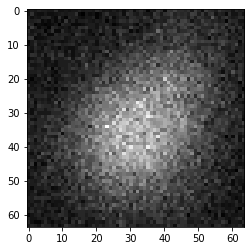

In [397]:
doplt(data[:,:,:].mean(-1))
plt.title('average over all frames')

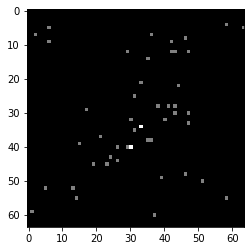

In [398]:
doplt(data[:,:,:1].mean(-1)) 
plt.title('one frame')

Text(0.5, 1.0, 'sim data Poisson shot noise')

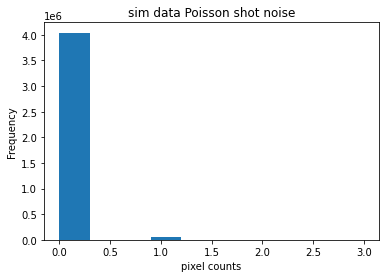

In [399]:
pd.Series(data.flatten().detach().numpy()).plot.hist()
plt.xlabel('pixel counts')
plt.title('sim data Poisson shot noise')

In [383]:
snr = (dose_gt*clean_signal).var() / data[:,:,0].var()
snr

tensor(0.0016)

# forward model functions

In [7]:
def make_clean_signal_multi_atom_batch_cuda(atom_centers,coords,sigma_signal_gt):
  """
  returns .shape (num_pix*num.pix,num_particle)
  """
  clean_signal = torch.zeros(coords.shape[0],atom_centers.shape[-1]).cuda()
  for atom_center in atom_centers:
    clean_signal += torch.exp(-((coords.reshape(-1,2,1)-atom_center.reshape(1,2,-1))**2).sum(1)/(2*sigma_signal_gt**2))
  return clean_signal


In [49]:
atom_centers_gt.shape

torch.Size([10, 2])

In [41]:
atom_center = atom_centers_gt[0]

In [42]:
torch.exp(-((coords.reshape(-1,2,1)-atom_center.reshape(1,2,-1))**2).sum(1)/(2*sigma_signal_gt**2)).shape

torch.Size([4096, 1])

4096

# NN architectures

In [245]:
class CPN_CNN(Module):   
  # https://openaccess.thecvf.com/content/ICCV2021W/LCI/html/Nashed_CryoPoseNet_End-to-End_Simultaneous_Learning_of_Single-Particle_Orientation_and_3D_Map_ICCVW_2021_paper.html
    def __init__(self):
        super(CPN_CNN, self).__init__()
        self.size_out = 3
        self.linear_layer_width = 512

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.linear_layers = Sequential(
            # should match print("shape: {}".format(x.shape[1])) in forward
            Linear(8192, self.linear_layer_width),
            ReLU(inplace=True),
            Linear(self.linear_layer_width, self.linear_layer_width),
            ReLU(inplace=True),
            Linear(self.linear_layer_width, self.size_out)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        #print("shape: {}".format(x.shape[1]))
        x = self.linear_layers(x)
        return x
net = CPN_CNN()
net(torch.zeros(2,1,num_pix,num_pix)).shape
# sum(p.numel() for p in cnn.parameters() if p.requires_grad)

torch.Size([2, 3])

# model and guide

## shift, poisson shot noise

In [393]:
net = CPN_CNN().cuda()
do_log=False

atom_centers_gt_cuda = atom_centers_gt.cuda()
coords_cuda = coords.cuda()
sigma_signal_gt_cuda = sigma_signal_gt.cuda()

shift_loc_gt_cuda = shift_loc_gt.cuda()
shift_scale_gt_cuda = shift_scale_gt.cuda()
dose_gt_cuda = dose_gt.cuda()
bg_gt_cuda = bg_gt.cuda()
def model(mini_batch):
  """
  simulates a batch of particles, corresponding to observed 2d rotated particles
  no interpolation because analytical form of molecule potential used
  """
  size_mini_batch = mini_batch.shape[-1]
  batch_idxs = torch.arange(size_mini_batch)
  if do_log: print('model mini_batch.shape',mini_batch.shape)
  with pyro.plate('mini_batch',size_mini_batch):

    gt_dist_x = dist.Normal(shift_loc_gt_cuda,shift_scale_gt_cuda)
    gt_dist_y = dist.Normal(shift_loc_gt_cuda,shift_scale_gt_cuda)
    if do_log: print('model gt_dist',gt_dist)

    shifts_x = pyro.sample('shift_x',gt_dist_x)
    shifts_y = pyro.sample('shift_y',gt_dist_y)

    shifts = torch.vstack([shifts_x,shifts_y])
    if do_log: print('model shifts.shape',shifts.shape)
    if do_log: print('model shifts',shifts)

    atom_centres_shift = atom_centers_gt_cuda.reshape(-1,2,1) - shifts.reshape(1,2,-1) # already on device
    clean_signal = make_clean_signal_multi_atom_batch_cuda(atom_centres_shift,coords_cuda,sigma_signal_gt_cuda).reshape(num_pix,num_pix,-1)
    if do_log: print('model clean_signal.shape',clean_signal.shape)
    
    with pyro.plate('pixel_x',num_pix, dim=-2):
      with pyro.plate('pixel_y',num_pix, dim=-3):
        distrib = dist.Poisson(dose_gt_cuda*clean_signal + bg_gt_cuda)
        if do_log: print('model particle distribution',distrib)
        if do_log: print('model mini_batch.shape',mini_batch.shape)
        return pyro.sample("shot_noise", distrib, obs=mini_batch.reshape(num_pix,num_pix,batch_size)) # upon each of these noiseless, projected particles, noise is applied

def guide(mini_batch): # the proposal distribution
  """
  neural net will be trained on many particles to predict params of distribution
  """

  pyro.module("net", net)
  size_mini_batch = mini_batch.shape[-1]
  batch_idxs = torch.arange(size_mini_batch)
  mini_batch_swap = torch.swapaxes(mini_batch,0,2)
  with pyro.plate('mini_batch', size_mini_batch, dim=-1):
    
    lam = net(mini_batch_swap.reshape(-1,1,num_pix,num_pix))
    if do_log: print('guide lam', lam)
    loc_x, loc_y, log_scale = lam[:,0], lam[:,1], lam[:,2]
    scale = torch.exp(log_scale)

    if do_log: print('loc_x', loc_x)
    if do_log: print('scale', scale)

    distrib_x = dist.Normal(loc_x, scale) 
    distrib_y = dist.Normal(loc_y, scale) 
    if do_log: print('guide distrib',distrib_x)
    shift_x = pyro.sample("shift_x", distrib_x)
    shift_y = pyro.sample("shift_y", distrib_y)
    shift = torch.vstack([shift_x,shift_y])
    if do_log: print('guide shift',shift)
    return shift

pyro.clear_param_store()
svi = pyro.infer.SVI(model=model, 
                     guide=guide, 
                     optim=pyro.optim.Adam({"lr": 1e-5}), 
                     loss=pyro.infer.Trace_ELBO())

losses = []
n_epochs = 100
batch_size = 10
n_particles = 1000
epoch_size = n_particles
assert epoch_size % batch_size == 0

for ep in range(n_epochs):
  if n_epochs < 10 or ep % (n_epochs//10) == 0: print('epoch {}'.format(ep))
  random_idx = torch.randperm(n_particles) 
  permutation = data.index_select(-1,random_idx)
  for i in range(0,epoch_size,batch_size):
    mini_batch = permutation[:,:,i:i+batch_size]
    losses.append(svi.step(mini_batch.cuda()))


epoch 0
epoch 10
epoch 20
epoch 30
epoch 40
epoch 50
epoch 60
epoch 70
epoch 80
epoch 90


Text(0.5, 1.0, 'loss')

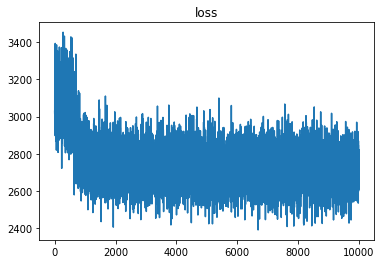

In [394]:
pd.Series(losses).plot()
plt.title('loss')

In [395]:
amortized_predictions = []
n_particles=1000
for idx_particle in range(n_particles):
  if n_particles < 10 or idx_particle % (n_particles//10) == 0: print('particle {}'.format(idx_particle))
  one_particle = data[:,:,idx_particle]
  amortized_lam = guide(one_particle.reshape(num_pix,num_pix,1).cuda())[:,0]
  amortized_predictions.append(amortized_lam.tolist())
amortized_predictions = tensor(amortized_predictions).T

particle 0
particle 100
particle 200
particle 300
particle 400
particle 500
particle 600
particle 700
particle 800
particle 900


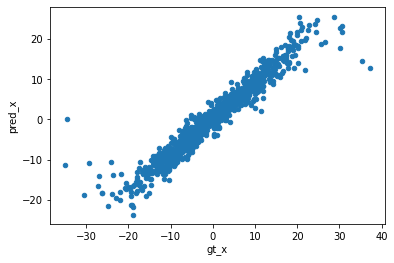

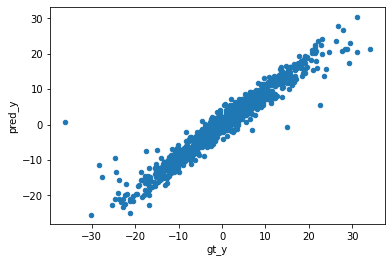

In [396]:
pred_gt_df = pd.DataFrame(torch.vstack([amortized_predictions,shift_gt[:,:n_particles]]).detach().numpy().T, columns=['pred_x','pred_y','gt_x','gt_y'])
pred_gt_df.plot.scatter(x='gt_x',y='pred_x')
pred_gt_df.plot.scatter(x='gt_y',y='pred_y')

# 2d fourier

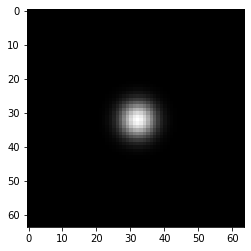

In [156]:
clean_signal = make_clean_signal_multi_atom(tensor([[0.,0.]]),coords,sigma_signal_gt).reshape(num_pix,num_pix)
doplt(clean_signal)

In [85]:
def do_fft_2d(arr_2d_r_centered,**kwargs):
  arr_r = torch.fft.fftshift(arr_2d_r_centered)
  arr_f = torch.fft.fftn(arr_r,**kwargs) 
  arr_f_centered = torch.fft.ifftshift(arr_f)
  return arr_f_centered

def do_ifft_2d(arr_2d_f_centered,**kwargs):
  arr_f = torch.fft.ifftshift(arr_2d_f_centered)
  arr_r = torch.fft.ifftn(arr_f,**kwargs) 
  arr_r_centered = torch.fft.fftshift(arr_r)
  return arr_r_centered

# def do_fft_shift(arr_2d_r_centered):


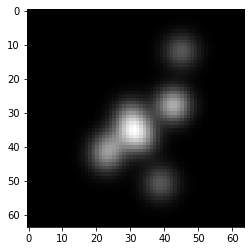

In [71]:
doplt(clean_signal[:,:,1].cpu())


In [81]:
# arr_r = torch.fft.fftshift(clean_signal)
# arr_f = torch.fft.ifftn(arr_r,dim=(0,1)) # what dims the data is in
# arr_f_centered = torch.fft.ifftshift(arr_f)

In [ ]:
# doplt(arr_f_centered.real[:,:,0].cpu())

# torch.allclose(arr_f_centered[:,:,0],arr_f_centered[:,:,1])

# fourier pixel shift

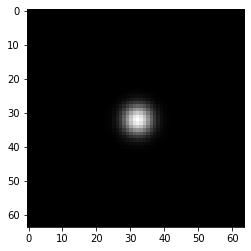

In [210]:
arr_f_centered = do_fft_2d(clean_signal)
doplt(arr_f_centered.real)


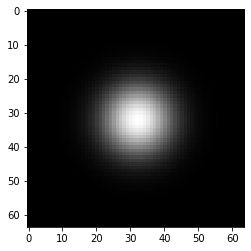

In [160]:
doplt(do_ifft_2d(arr_f_centered).real)

In [ ]:
def fourier_shift_2d(arr_r_centered,shift):
  arr_f_centered = do_fft_2d(arr_r_centered)
  def make_fourier_mod(i_shift, j_shift):
    
    ax = torch.arange(-num_pix//2, num_pix//2)
    i_grid, j_grid = torch.meshgrid(ax, ax, indexing='ij')
    phase = -(i_shift * i_grid + j_shift * j_grid) * 2* torch.pi / num_pix 
    mod = torch.exp(1j*phase)
    return mod
  i_shift, j_shift = shift
  mod = make_fourier_mod(i_shift, j_shift)
  arr_r_shifted = do_ifft_2d(arr_f_centered*mod).real
  return arr_r_shifted

shift = tensor([10.5,10.5])
arr_r_shifted = fourier_shift_2d(clean_signal,shift)
doplt(arr_r_shifted)

## data and latents --> clean data
use custom inversion method to reconstruct from data, using estimated latents

In [14]:
n_particles=1000
data_shifted_ideal = torch.zeros_like(data)
data_shifted_reco = torch.zeros_like(data)

for idx_particle in range(n_particles):
  data_shifted_ideal[:,:,idx_particle] = fourier_shift_2d(data[:,:,idx_particle],shift_gt[:,idx_particle])
  data_shifted_reco[:,:,idx_particle] = fourier_shift_2d(data[:,:,idx_particle],amortized_predictions[:,idx_particle])
  
  

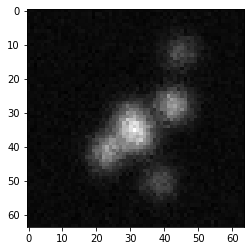

In [15]:
doplt(data_shifted_ideal.mean(-1))

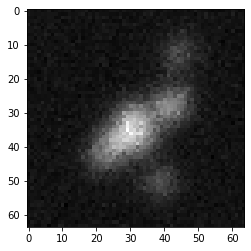

In [376]:
doplt(data_shifted_reco.mean(-1))

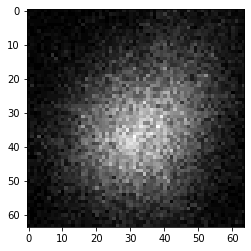

In [325]:
doplt(data.mean(-1))

We see that we can unblur the data by unshifting it
* using low dose "counting frame" synthetic data

# ctf

## `compute_ctf_2d`

In [8]:
def make_ctf_clean_signal_batch(clean_signal_f,dfs):
  ctfs = torch.sin(dfs.reshape(1,-1)*(k**2).reshape(-1,1))
  clean_signal_f_ctf = (clean_signal_f.reshape(-1,1)*ctfs).T
  clean_signal_f_ctf = torch.fft.ifftshift(clean_signal_f_ctf, dim=1)
  clean_signal_r_ctf = torch.fft.ifftn(clean_signal_f_ctf,dim=1)
  clean_signal_r_ctf = torch.fft.fftshift(clean_signal_r_ctf, dim=1).T
  return clean_signal_r_ctf

In [11]:
make_ctf_clean_signal_batch(clean_signal_f,dfs).shape

NameError: ignored

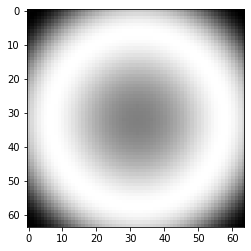

In [232]:
def compute_ctf_2d_batch(defoci):
  def ctf_precompute(num_pix):
    k = torch.arange(-num_pix//2,num_pix//2)
    kx, ky = torch.meshgrid(k, k, indexing='ij')
    k = torch.hypot(kx.float(), ky.float()) / num_pix
    k2 = k*k
    return k2
  k2 = ctf_precompute(num_pix)
  
  ctf_2d = torch.sin(defoci.reshape(1,1,-1)*k2.reshape(num_pix,num_pix,1))
  return ctf_2d

defoci = tensor([10,20])
ctf_2d = compute_ctf_2d(defoci)

doplt(ctf_2d[:,:,0])

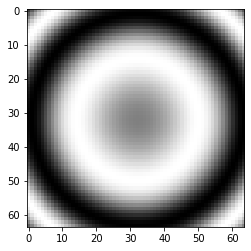

In [233]:
doplt(ctf_2d[:,:,1])

In [ ]:
atom_centers = atom_centers_gt.reshape(-1,2,1)
clean_signal = make_clean_signal_multi_atom_batch_cuda(atom_centers.cuda(),coords.cuda(),sigma_signal_gt.cuda()).reshape(num_pix,num_pix,-1)
clean_signal_f = do_fft_2d(clean_signal,dim=(0,1))
clean_signal_ctf = do_ifft_2d(clean_signal_f * ctf_2d.cuda(), dim=(0,1))
clean_signal_ctf
# make batch ctf
# batch fft different real space projections
# convolute batch ctf
# big vectorized reshaped array

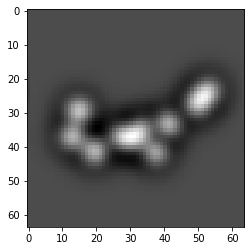

In [235]:
doplt(clean_signal_ctf.real[:,:,0].cpu())

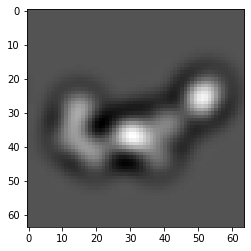

In [157]:
doplt(clean_signal_ctf.real[:,:,1].cpu())

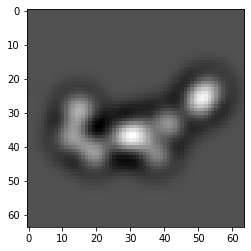

In [150]:
doplt((clean_signal_ctf.real[:,:,0] - clean_signal_ctf.real[:,:,1]).cpu())

In [151]:
torch.isclose(clean_signal_ctf.real[:,:,0],clean_signal_ctf.real[:,:,1]).float().mean()

tensor(0.0474, device='cuda:0')

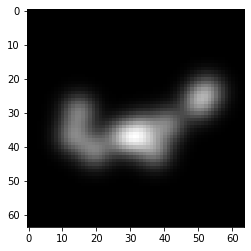

In [158]:
doplt(clean_signal[:,:,0].cpu())

In [30]:
coords.shape

torch.Size([4096, 2])

## simulated data

In [445]:
def angle_to_rotation(angle_rad):
  c,s = torch.cos(angle_rad), torch.sin(angle_rad)
  rotation = torch.tensor([[c,-s],
               [s,c]])
  return rotation


n_particles=1000

df_loc_gt = tensor(100.)
df_scale_gt = tensor(30.)
gt_dist = dist.Normal(df_loc_gt,df_scale_gt)
# df_offset = tensor(10.)
df_gt = torch.zeros(n_particles)

# gt_dist = dist.Bernoulli(0.5)
# df_offset = tensor(100.)

data_clean = torch.zeros(num_pix,num_pix,n_particles)
# sigma_noise=tensor(0.1).cuda()
dose_gt = tensor(100.)
bg_gt = tensor(10.)


# angle_rad_gt = torch.linspace(0,torch.deg2rad(tensor(90)),n_particles)
for idx_particle in range(n_particles):
  if n_particles < 10 or idx_particle % (n_particles//10) == 0: print('particle {}'.format(idx_particle))
  df = gt_dist.sample()
  # if gt_dist.sample():
  #   df = 10
  # else:
  #   df = 300
    #df = df_offset*gt_dist.sample() + df_offset
  
  df_gt[idx_particle] = df 

  atom_centers = atom_centers_gt.reshape(-1,2,1) # important for getting batch shape to make_clean_signal_multi_atom_batch_cuda
  clean_signal = make_clean_signal_multi_atom_batch_cuda(atom_centers.cuda(),coords.cuda(),sigma_signal_gt.cuda()).reshape(num_pix,num_pix,-1)
  clean_signal_f = do_fft_2d(clean_signal,dim=(0,1))
  ctf_2d = compute_ctf_2d(df + df_offset)
  clean_signal_ctf = do_ifft_2d(clean_signal_f * ctf_2d.cuda(), dim=(0,1)).real 
  data_clean[:,:,idx_particle] = clean_signal_ctf[:,:,0]
  #data[:,:,idx_particle] = dist.Normal(clean_signal_ctf, sigma_noise).sample()[:,:,0]

global_scale_dose = data_clean.min()
data = dist.Poisson(dose_gt*(data_clean-global_scale_dose) + bg_gt).sample()


particle 0
particle 100
particle 200
particle 300
particle 400
particle 500
particle 600
particle 700
particle 800
particle 900


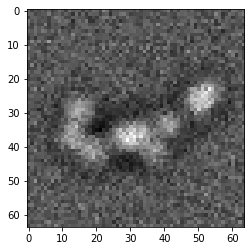

In [446]:
doplt(data[:,:,0])

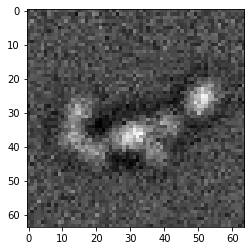

In [440]:
doplt(data[:,:,1])

## NN

In [412]:
class CPN_CNN(Module):   
  # https://openaccess.thecvf.com/content/ICCV2021W/LCI/html/Nashed_CryoPoseNet_End-to-End_Simultaneous_Learning_of_Single-Particle_Orientation_and_3D_Map_ICCVW_2021_paper.html
    def __init__(self):
        super(CPN_CNN, self).__init__()
        self.size_out = 2
        self.linear_layer_width = 512

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.linear_layers = Sequential(
            # should match print("shape: {}".format(x.shape[1])) in forward
            Linear(8192, self.linear_layer_width),
            ReLU(inplace=True),
            Linear(self.linear_layer_width, self.linear_layer_width),
            ReLU(inplace=True),
            Linear(self.linear_layer_width, self.size_out),
            #nn.Sigmoid()
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        #print("shape: {}".format(x.shape[1]))
        x = self.linear_layers(x)
        return x
net = CPN_CNN()
net(torch.zeros(2,1,num_pix,num_pix)).shape
# sum(p.numel() for p in cnn.parameters() if p.requires_grad)

torch.Size([2, 2])

## model and guide

In [451]:
net = CPN_CNN().cuda()
do_log=False

atom_centers_cuda = atom_centers_gt.reshape(-1,2,1).cuda()
coords_cuda = coords.cuda()
sigma_signal_gt_cuda = sigma_signal_gt.cuda()

# can precopute this part
clean_signal = make_clean_signal_multi_atom_batch_cuda(atom_centers_cuda,coords_cuda,sigma_signal_gt_cuda).reshape(num_pix,num_pix,-1)
clean_signal_f = do_fft_2d(clean_signal,dim=(0,1))

df_loc_gt_cuda = df_loc_gt.cuda()
df_scale_gt_cuda = df_scale_gt.cuda()
# df_offset_cuda = tensor(10.).cuda()

dose_gt_cuda = dose_gt.cuda()
global_scale_dose_cuda = global_scale_dose.cuda()
bg_gt_cuda = bg_gt.cuda()

def model(mini_batch):
  """
  simulates a batch of particles, corresponding to observed 2d rotated particles
  no interpolation because analytical form of molecule potential used
  """
  size_mini_batch = mini_batch.shape[-1]
  batch_idxs = torch.arange(size_mini_batch)
  if do_log: print('model mini_batch.shape',mini_batch.shape)
  with pyro.plate('mini_batch',size_mini_batch):

    gt_dist = dist.Normal(df_loc_gt_cuda,df_scale_gt_cuda)
    if do_log: print('model gt_dist',gt_dist)
    dfs = pyro.sample('df',gt_dist) #+ df_offset

    #gt_dist = dist.Bernoulli((torch.ones(size_mini_batch)/2).cuda())
    #df = df_offset_cuda*pyro.sample('df_state', gt_dist) + df_offset_cuda

    # clean_signal = make_clean_signal_multi_atom_batch_cuda(atom_centers_cuda,coords_cuda,sigma_signal_gt_cuda).reshape(num_pix,num_pix,-1)
    # clean_signal_f = do_fft_2d(clean_signal,dim=(0,1))
    ctf_2d = compute_ctf_2d(dfs.cpu())
    clean_signal_ctf = do_ifft_2d(clean_signal_f * ctf_2d.cuda(), dim=(0,1)).real
    #clean_signal_ctf_f = clean_signal_f * ctf_2d.cuda()

    if do_log: print('model clean_signal_ctf.shape',clean_signal_ctf.shape)
    if do_log: print('model clean_signal_ctf',clean_signal_ctf[0,0,0])
    
    with pyro.plate('pixel_x',num_pix, dim=-2):
      with pyro.plate('pixel_y',num_pix, dim=-3):
        #distrib = dist.Normal(clean_signal_ctf, sigma_noise)
        if clean_signal_ctf.min() < global_scale_dose_cuda:
          safe = clean_signal_ctf.min()
        else:
          safe = global_scale_dose_cuda
        distrib = dist.Poisson(dose_gt_cuda*(clean_signal_ctf-safe) + bg_gt_cuda)
        if do_log: print('model particle distribution',distrib)
        if do_log: print('model mini_batch.shape',mini_batch.shape)

        sim_obs =  pyro.sample("shot_noise", distrib, obs=mini_batch.reshape(num_pix,num_pix,batch_size)) # upon each of these noiseless, projected particles, noise is applied
        if do_log: print('model sim_obs',sim_obs[0,0,0])
        return sim_obs

def guide(mini_batch): # the proposal distribution
  """
  neural net will be trained on many particles to predict params of distribution
  """

  pyro.module("net", net)
  size_mini_batch = mini_batch.shape[-1]
  batch_idxs = torch.arange(size_mini_batch)
  mini_batch_swap = torch.swapaxes(mini_batch,0,2)
  with pyro.plate('mini_batch', size_mini_batch, dim=-1):
    
    lam = net(mini_batch_swap.reshape(-1,1,num_pix,num_pix))
    if do_log: print('guide lam', lam)
    loc, log_scale = lam[:,0], lam[:,1]
    # loc = lam[:,0]
    scale = torch.exp(log_scale)
    # if do_log: print('loc', loc)
    # if do_log: print('scale', scale)

    # binary = sigmoid(lam)[:,0]
    #binary = lam[:,0]
    #if do_log: print('guide binary', binary)

    distrib = dist.Normal(loc, scale) 
    #distrib = dist.Bernoulli(binary)
    #    dfs = pyro.sample("df_state", distrib)
    if do_log: print('guide distrib',distrib)
    dfs = pyro.sample("df", distrib)
    if do_log: print('guide dfs',dfs)
    return dfs

pyro.clear_param_store()
svi = pyro.infer.SVI(model=model, 
                     guide=guide, 
                     optim=pyro.optim.Adam({"lr": 1e-4}), 
                     loss=pyro.infer.Trace_ELBO())

losses = []
n_epochs = 10
batch_size = 10
n_particles = 1000
epoch_size = n_particles
assert epoch_size % batch_size == 0

# data_f = do_fft_2d(data,dim=(0,1))
for ep in range(n_epochs):
  if n_epochs < 10 or ep % (n_epochs//10) == 0: print('epoch {}'.format(ep))
  random_idx = torch.randperm(n_particles) 
  permutation = data.index_select(-1,random_idx)
  for i in range(0,epoch_size,batch_size):
    mini_batch = permutation[:,:,i:i+batch_size]
    losses.append(svi.step(mini_batch.cuda()))


epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9


In [ ]:
# for ep in range(n_epochs):
#   if n_epochs < 10 or ep % (n_epochs//10) == 0: print('epoch {}'.format(ep))
#   random_idx = torch.randperm(n_particles) 
#   permutation = data.index_select(-1,random_idx)
#   for i in range(0,epoch_size,batch_size):
#     mini_batch = permutation[:,:,i:i+batch_size]
#     losses.append(svi.step(mini_batch.cuda()))

Text(0.5, 1.0, 'loss')

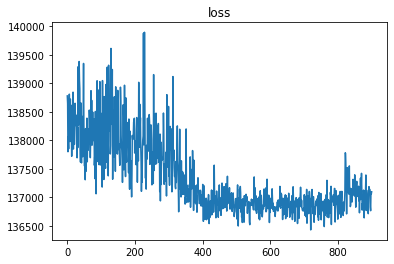

In [464]:
pd.Series(losses[100:]).plot(logy=False)
plt.title('loss')

In [452]:
amortized_predictions = []
n_particles=1000
for idx_particle in range(n_particles):
  if n_particles < 10 or idx_particle % (n_particles//10) == 0: print('particle {}'.format(idx_particle))
  one_particle = data[:,:,idx_particle]
  amortized_lam = guide(one_particle.reshape(num_pix,num_pix,1).cuda()).item()
  amortized_predictions.append(amortized_lam)
amortized_predictions = tensor(amortized_predictions)

particle 0
particle 100
particle 200
particle 300
particle 400
particle 500
particle 600
particle 700
particle 800
particle 900


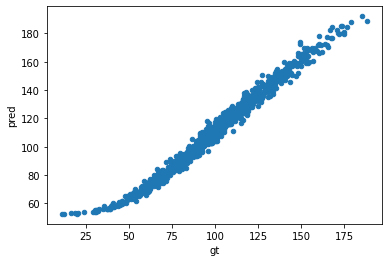

In [453]:
pred_gt_df = pd.DataFrame(torch.vstack([amortized_predictions,df_gt[:n_particles]]).detach().numpy().T, columns=['pred','gt'])
pred_gt_df.plot.scatter(x='gt',y='pred')

In [ ]:
# predictions = amortized_predictions.detach().numpy().astype(bool)
# labels = (df_gt[:n_particles]>df_gt.min()).detach().numpy().astype(bool)
# confusion_matrix(predictions, labels)

# shift + ctf
* in guide
  * predict shift
  * modify observe with predicted shift (sampled)
  * predict ctf from modified observe
  * (once deconvoluted can predict rotation from that image).
  * (no reshaping issues since just sample one latent per mini batch observe)